## DATA PROCESSING

In [130]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import datetime
from datetime import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
%matplotlib inline

In [85]:
# Import the data into their respective dataframes
dataframes = {}
for dirname, _, filenames in os.walk('./football_dataset/'):
    for filename in filenames:
        file_name = filename.split('.')[0] + "_df"
        filepath = os.path.join(dirname, filename)
        df = pd.read_csv(filepath, sep=",", encoding="UTF-8")
        dataframes[file_name] = df
        print(file_name, df.shape)

print('\nData imported')

appearances_df (1643394, 13)
clubs_df (439, 17)
club_games_df (143016, 11)
competitions_df (44, 11)
games_df (71508, 23)
game_events_df (994836, 10)
game_lineups_df (2191911, 10)
players_df (32409, 23)
player_valuations_df (487916, 5)
transfers_df (77936, 10)

Data imported


In [86]:
# Initialise the dataframes so that there is no undefined error
appearances_df = dataframes['appearances_df']
clubs_df = dataframes['clubs_df']
club_games_df = dataframes['club_games_df']
competitions_df = dataframes['competitions_df']
games_df = dataframes['games_df']
game_events_df = dataframes['game_events_df']
game_lineups_df = dataframes['game_lineups_df']
players_df = dataframes['players_df']
player_valuations_df = dataframes['player_valuations_df']
transfers_df = dataframes['transfers_df']

In [87]:
# Remove useless columns
players_df = players_df.drop(columns=["image_url", "url", "contract_expiration_date", "last_season"])

# Drop players without a date of birth
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
players_df = players_df[players_df['date_of_birth'].isnull() == False]

# Drop players without a market value
players_df = players_df[players_df.highest_market_value_in_eur.isnull() == False]

# Set players' ages to realtime
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 
players_df

,player_id,first_name,last_name,name,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,age
0,10,Miroslav,Klose,Miroslav Klose,398,miroslav-klose,Poland,Opole,Germany,1978-06-09,Centre-Forward,Attack,right,184.0,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,46
1,26,Roman,Weidenfeller,Roman Weidenfeller,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06,Goalkeeper,Goalkeeper,left,190.0,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0,44
2,65,Dimitar,Berbatov,Dimitar Berbatov,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30,Centre-Forward,Attack,NaN,NaN,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,44
3,77,NaN,Lúcio,Lúcio,506,lucio,Brazil,Brasília,Brazil,1978-05-08,Centre-Back,Defender,NaN,NaN,NaN,IT1,Juventus Football Club,200000.0,24500000.0,47
4,80,Tom,Starke,Tom Starke,27,tom-starke,East Germany (GDR),Freital,Germany,1981-03-18,Goalkeeper,Goalkeeper,right,194.0,IFM,L1,FC Bayern München,100000.0,3000000.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,1294049,Tomás,Silva,Tomás Silva,2503,tomas-silva,Portugal,Porto,Portugal,2006-05-25,Left-Back,Defender,left,175.0,TGC,PO1,Boavista Futebol Clube,100000.0,100000.0,18
32401,1294052,João,Barros,João Barros,2503,joao-barros,Portugal,Porto,Portugal,2006-01-10,Left Winger,Attack,right,184.0,AGREF International,PO1,Boavista Futebol Clube,150000.0,150000.0,19
32403,1296876,Marc,Domènech,Marc Domènech,237,marc-domenech,Spain,Llucmajor,Spain,2006-12-01,Centre-Forward,Attack,NaN,NaN,NaN,ES1,Real Club Deportivo Mallorca S.A.D.,500000.0,500000.0,18
32404,1302421,NaN,João Neto,João Neto,6992,joao-neto,NaN,NaN,Brazil,2003-02-04,Right Winger,Attack,right,178.0,ADRIANO SPORTS,UKR1,ZAO FK Chornomorets Odessa,100000.0,100000.0,22


In [88]:
# Add year to player valuations
player_valuations_df['date']=pd.to_datetime(player_valuations_df['date'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['date'].dt.year

# Add position to player valuations
position_df = players_df.copy()
position_df = position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'age'], axis=1)
player_valuations_df = player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')
player_valuations_df

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,year,sub_position,position,agent_name
0,405973,2000-01-20,150000,3057,BE1,2000,Left Winger,Attack,NaN
1,405973,2016-02-07,250000,3057,BE1,2016,Left Winger,Attack,NaN
2,405973,2016-07-15,250000,3057,BE1,2016,Left Winger,Attack,NaN
3,405973,2017-01-01,150000,3057,BE1,2017,Left Winger,Attack,NaN
4,405973,2018-09-11,75000,3057,BE1,2018,Left Winger,Attack,NaN
...,...,...,...,...,...,...,...,...,...
487350,897479,2024-10-09,500000,82,L1,2024,Attacking Midfield,Midfield,CAA Stellar
487351,1296876,2024-10-11,500000,237,ES1,2024,Centre-Forward,Attack,NaN
487352,1121298,2024-10-14,500000,366,ES1,2024,Centre-Back,Defender,NaN
487353,1255616,2024-10-14,200000,3709,ES1,2024,Attacking Midfield,Midfield,Best of You


In [89]:
# add year to player appearances
appearances_df['date'] = pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year'] = appearances_df['date'].dt.year

# add position to appearances
value_df = players_df.copy()
value_df = value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'age'], axis=1)
appearances_df1 = value_df.merge(appearances_df, left_on='player_id', right_on='player_id')
appearances_df1

,player_id,position,agent_name,market_value_in_eur,appearance_id,game_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,year
0,10,Attack,ASBW Sport Marketing,1000000.0,2254965_10,2254965,398,398,2012-08-23,Miroslav Klose,ELQ,1,0,1,0,83,2012
1,10,Attack,ASBW Sport Marketing,1000000.0,2251263_10,2251263,398,398,2012-08-26,Miroslav Klose,IT1,1,0,0,0,90,2012
2,10,Attack,ASBW Sport Marketing,1000000.0,2251277_10,2251277,398,398,2012-09-02,Miroslav Klose,IT1,1,0,2,0,89,2012
3,10,Attack,ASBW Sport Marketing,1000000.0,2251283_10,2251283,398,398,2012-09-16,Miroslav Klose,IT1,0,0,1,0,90,2012
4,10,Attack,ASBW Sport Marketing,1000000.0,2262399_10,2262399,398,398,2012-09-20,Miroslav Klose,EL,0,0,0,0,90,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641823,1302421,Attack,ADRIANO SPORTS,100000.0,4431147_1302421,4431147,6992,6992,2024-08-21,João Neto,UKRP,0,0,0,0,90,2024
1641824,1302421,Attack,ADRIANO SPORTS,100000.0,4368761_1302421,4368761,6992,6992,2024-08-26,João Neto,UKR1,0,0,0,0,21,2024
1641825,1302421,Attack,ADRIANO SPORTS,100000.0,4368736_1302421,4368736,6992,6992,2024-08-31,João Neto,UKR1,0,0,0,0,14,2024
1641826,1302421,Attack,ADRIANO SPORTS,100000.0,4368868_1302421,4368868,6992,6992,2024-09-14,João Neto,UKR1,0,0,0,0,45,2024


## DATA EXPLORATION

### We will filter player's statistics and valuation to be limited to up till 2022

### Let's observe the players' information

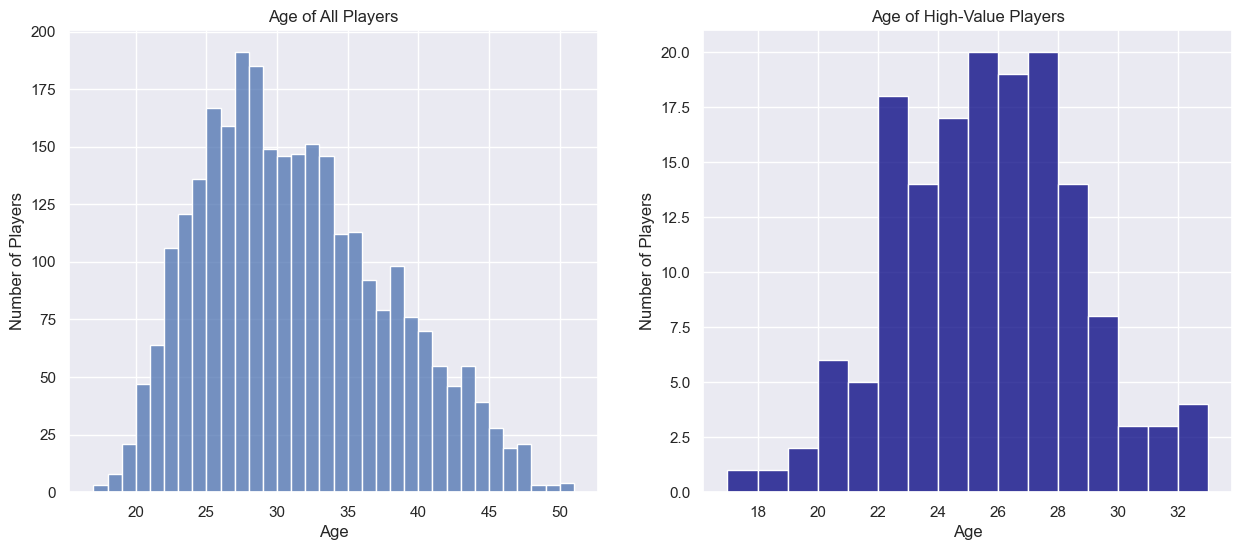

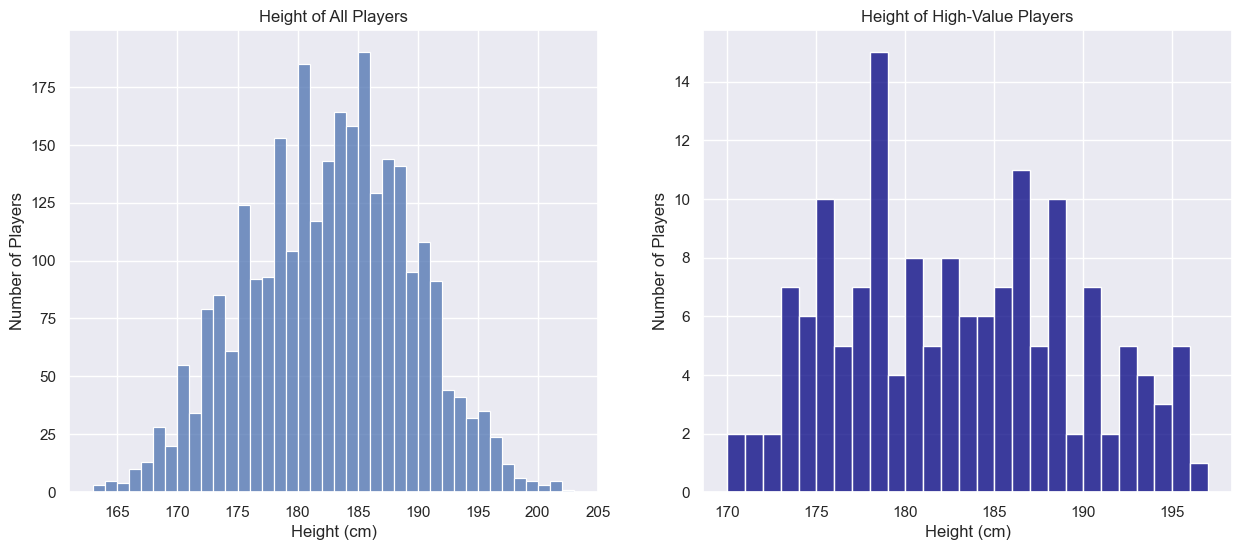

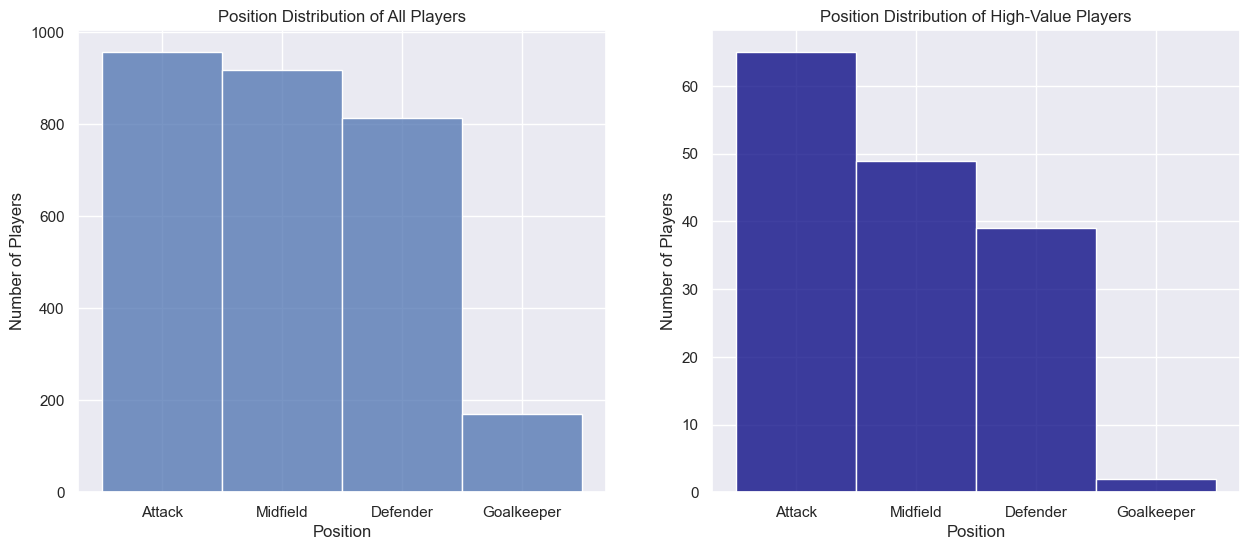

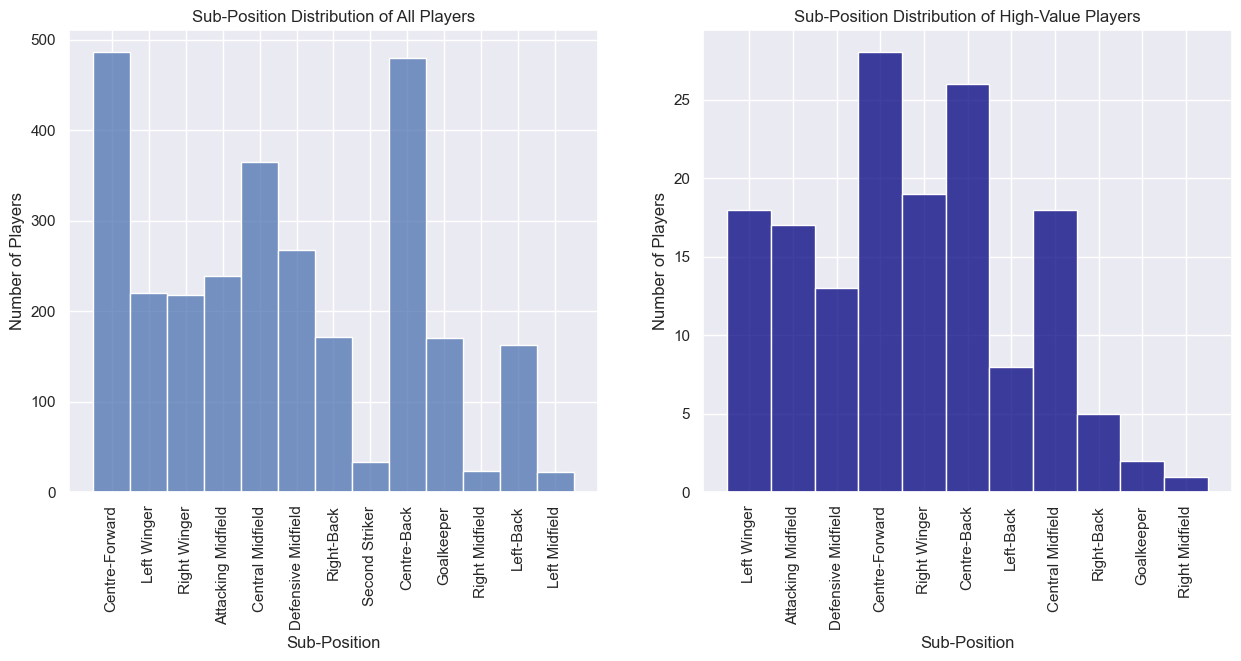

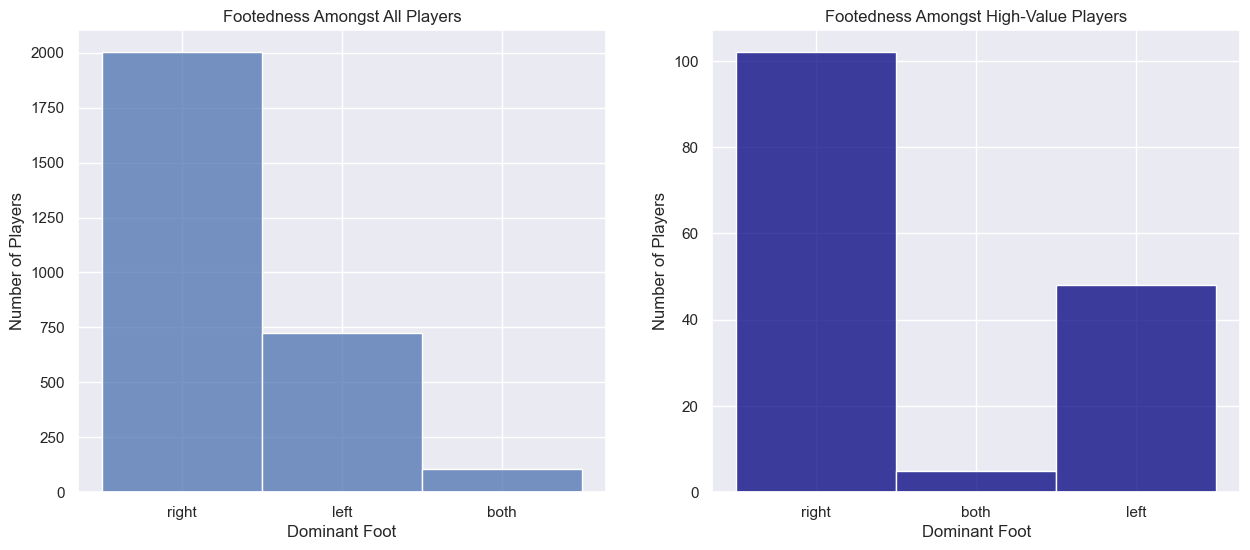

In [90]:
# Filter and sort the dataset
def preprocess_players_data(players_df):
    players_df_filtered = players_df[players_df['highest_market_value_in_eur'].notnull()]
    players_df_filtered = players_df_filtered[players_df_filtered['highest_market_value_in_eur'] >= 10000000]
    high_value_players_df = players_df_filtered[players_df_filtered['market_value_in_eur'] > 40000000]
    return players_df_filtered.sort_values("highest_market_value_in_eur", ascending=False), high_value_players_df

players_df1, high_value_players_df = preprocess_players_data(players_df)

# Plot distribution by a single variable
def plot_distribution(data, variable, title, xlabel, color, position, binwidth=1, rotation=0):
    plt.subplot(position)
    sns.histplot(data=data, x=variable, binwidth=binwidth, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Players')
    plt.xticks(rotation=rotation)
    plt.grid(True)

# Plot distributions for age and height of players
def plot_age_and_height_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'age', 'Age of All Players', 'Age', 'b', 121)
    plot_distribution(high_value_players_df, 'age', 'Age of High-Value Players', 'Age', 'navy', 122)

    plt.show()

    plt.figure(figsize=(15, 6))
    players_with_height = players_df[players_df['height_in_cm'].notnull()]

    plot_distribution(players_with_height, 'height_in_cm', 'Height of All Players', 'Height (cm)', 'b', 121)
    plot_distribution(high_value_players_df, 'height_in_cm', 'Height of High-Value Players', 'Height (cm)', 'navy', 122)

    plt.show()

# Plot position and sub-position distributions for players
def plot_position_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'position', 'Position Distribution of All Players', 'Position', 'b', 121)
    plot_distribution(high_value_players_df, 'position', 'Position Distribution of High-Value Players', 'Position', 'navy', 122)

    plt.show()

    plt.figure(figsize=(15, 6))
    
    plot_distribution(players_df, 'sub_position', 'Sub-Position Distribution of All Players', 'Sub-Position', 'b', 121, rotation=90)
    plot_distribution(high_value_players_df, 'sub_position', 'Sub-Position Distribution of High-Value Players', 'Sub-Position', 'navy', 122, rotation=90)

    plt.show()

# Plot footedness for players
def plot_footedness_distributions(players_df, high_value_players_df):
    plt.figure(figsize=(15, 6))

    plot_distribution(players_df, 'foot', 'Footedness Amongst All Players', 'Dominant Foot', 'b', 121)
    plot_distribution(high_value_players_df, 'foot', 'Footedness Amongst High-Value Players', 'Dominant Foot', 'navy', 122)

    plt.show()

# Run the plotting functions
plot_age_and_height_distributions(players_df1, high_value_players_df)
plot_position_distributions(players_df1, high_value_players_df)
plot_footedness_distributions(players_df1, high_value_players_df)

### Let's look at the player valuations over time, as well as sorted into Attack, Goalkeeper, Defender and Midfield

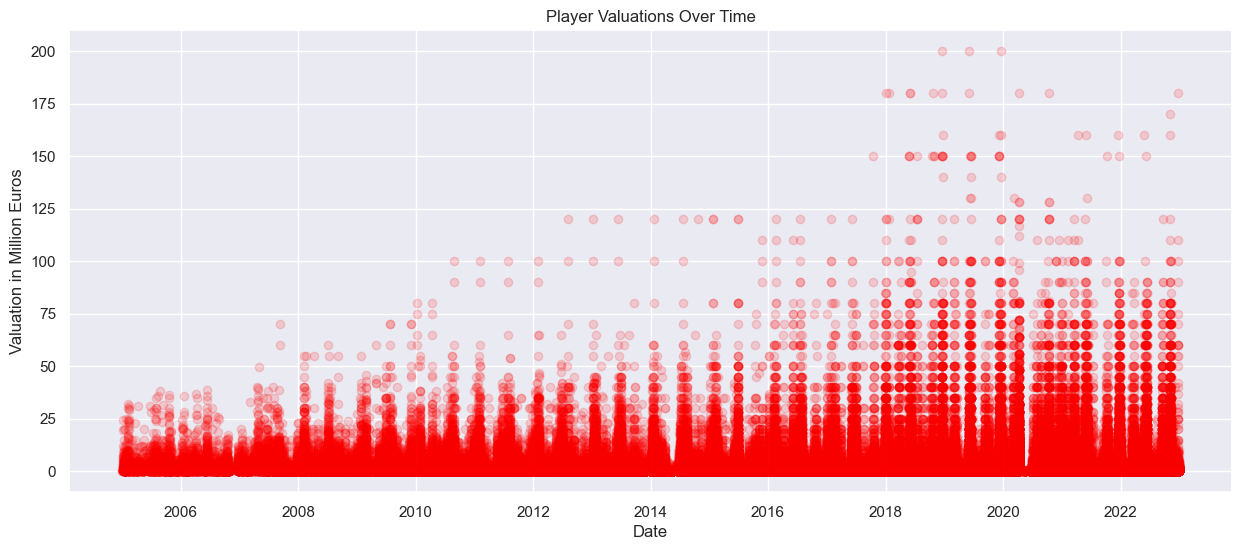

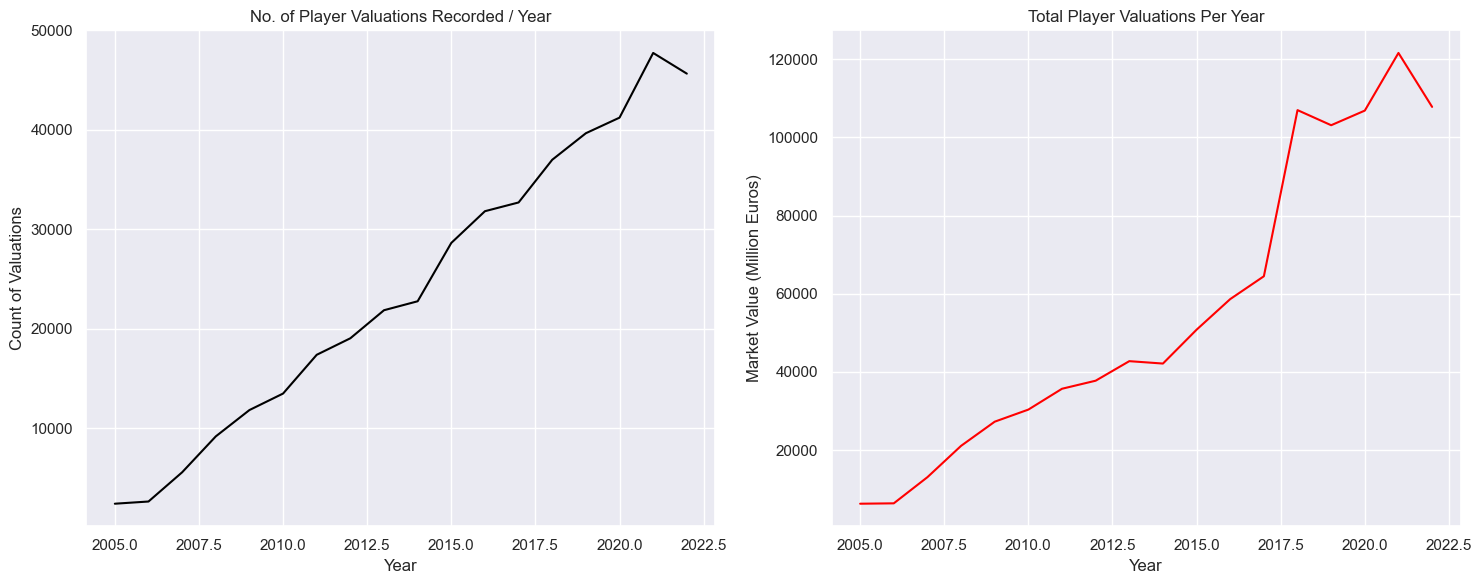

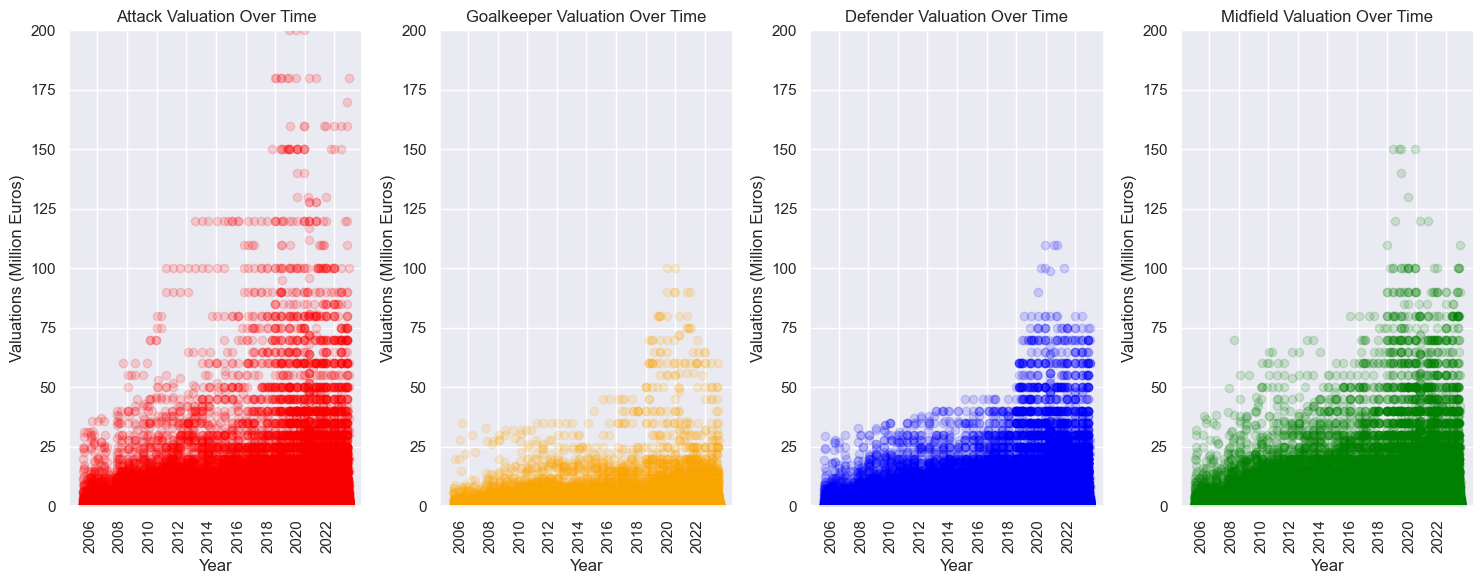

In [91]:
# Filter data based on year and market value
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004) & (player_valuations_df.year < 2023)]
high_value_player_valuations_df = player_valuations_df[player_valuations_df.market_value_in_eur > 40000000]
positions = players_df.position.unique()

# Overall player valuations over time
plt.figure(figsize=(15, 6))
plt.scatter(player_valuations_df['date'], player_valuations_df['market_value_in_eur'] / 1e6, color='red', alpha=0.15)
plt.xlabel('Date')
plt.ylabel('Valuation in Million Euros')
plt.title('Player Valuations Over Time')
plt.show()

# Yearly statistics on player valuations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Prepare yearly valuation statistics
yearly_counts = player_valuations_df.groupby('year')['market_value_in_eur'].count()
yearly_sums = player_valuations_df.groupby('year')['market_value_in_eur'].sum() / 1e6

# Plot the number of valuations recorded per year
ax1.plot(yearly_counts.index, yearly_counts, color='black')
ax1.set_title('No. of Player Valuations Recorded / Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count of Valuations')

# Plot the sum of player valuations per year
ax2.plot(yearly_sums.index, yearly_sums, color='red')
ax2.set_title('Total Player Valuations Per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Market Value (Million Euros)')

plt.tight_layout()
plt.show()

# Valuation data over time by player position
plt.figure(figsize=(15, 6))
colors = ['red', 'orange', 'blue', 'green', 'yellow']

positions = positions[:4]  
for i, position in enumerate(positions):
    plt.subplot(1, 4, i + 1)
    position_data = player_valuations_df[player_valuations_df.position == position]
    plt.scatter(position_data['date'], position_data['market_value_in_eur'] / 1e6, color=colors[i], alpha=0.15)
    plt.xlabel('Year')
    plt.ylabel('Valuations (Million Euros)')
    plt.title(f'{position} Valuation Over Time')
    plt.ylim(0, 200)
    plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

### Observe more specific player valuations based on age

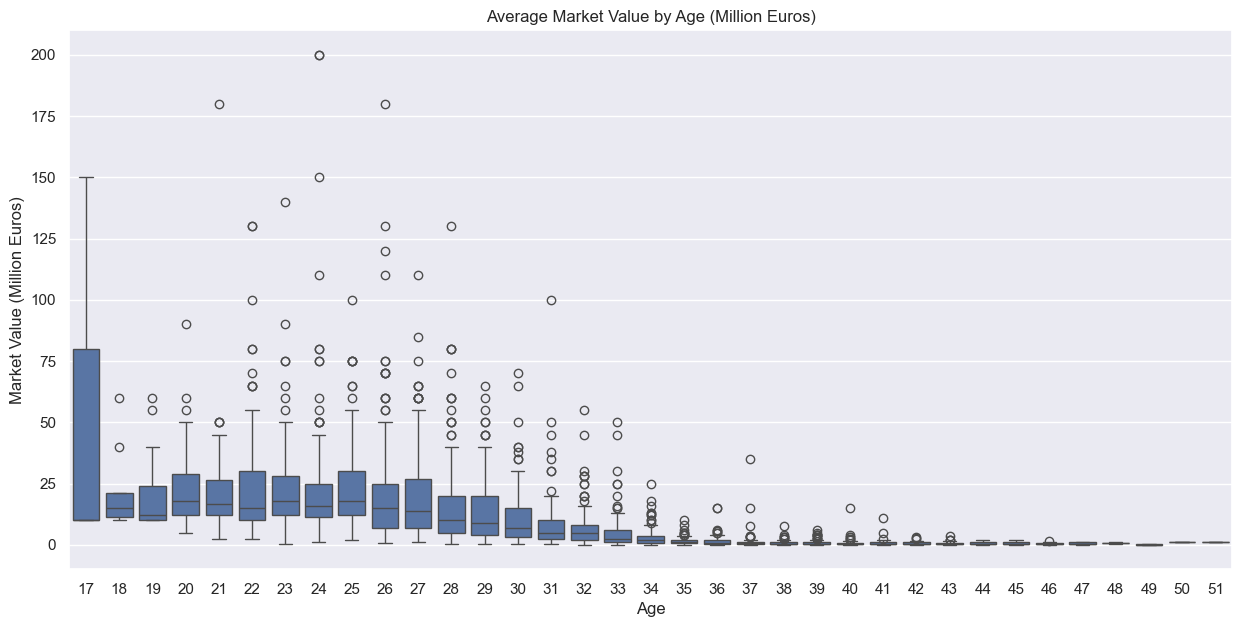

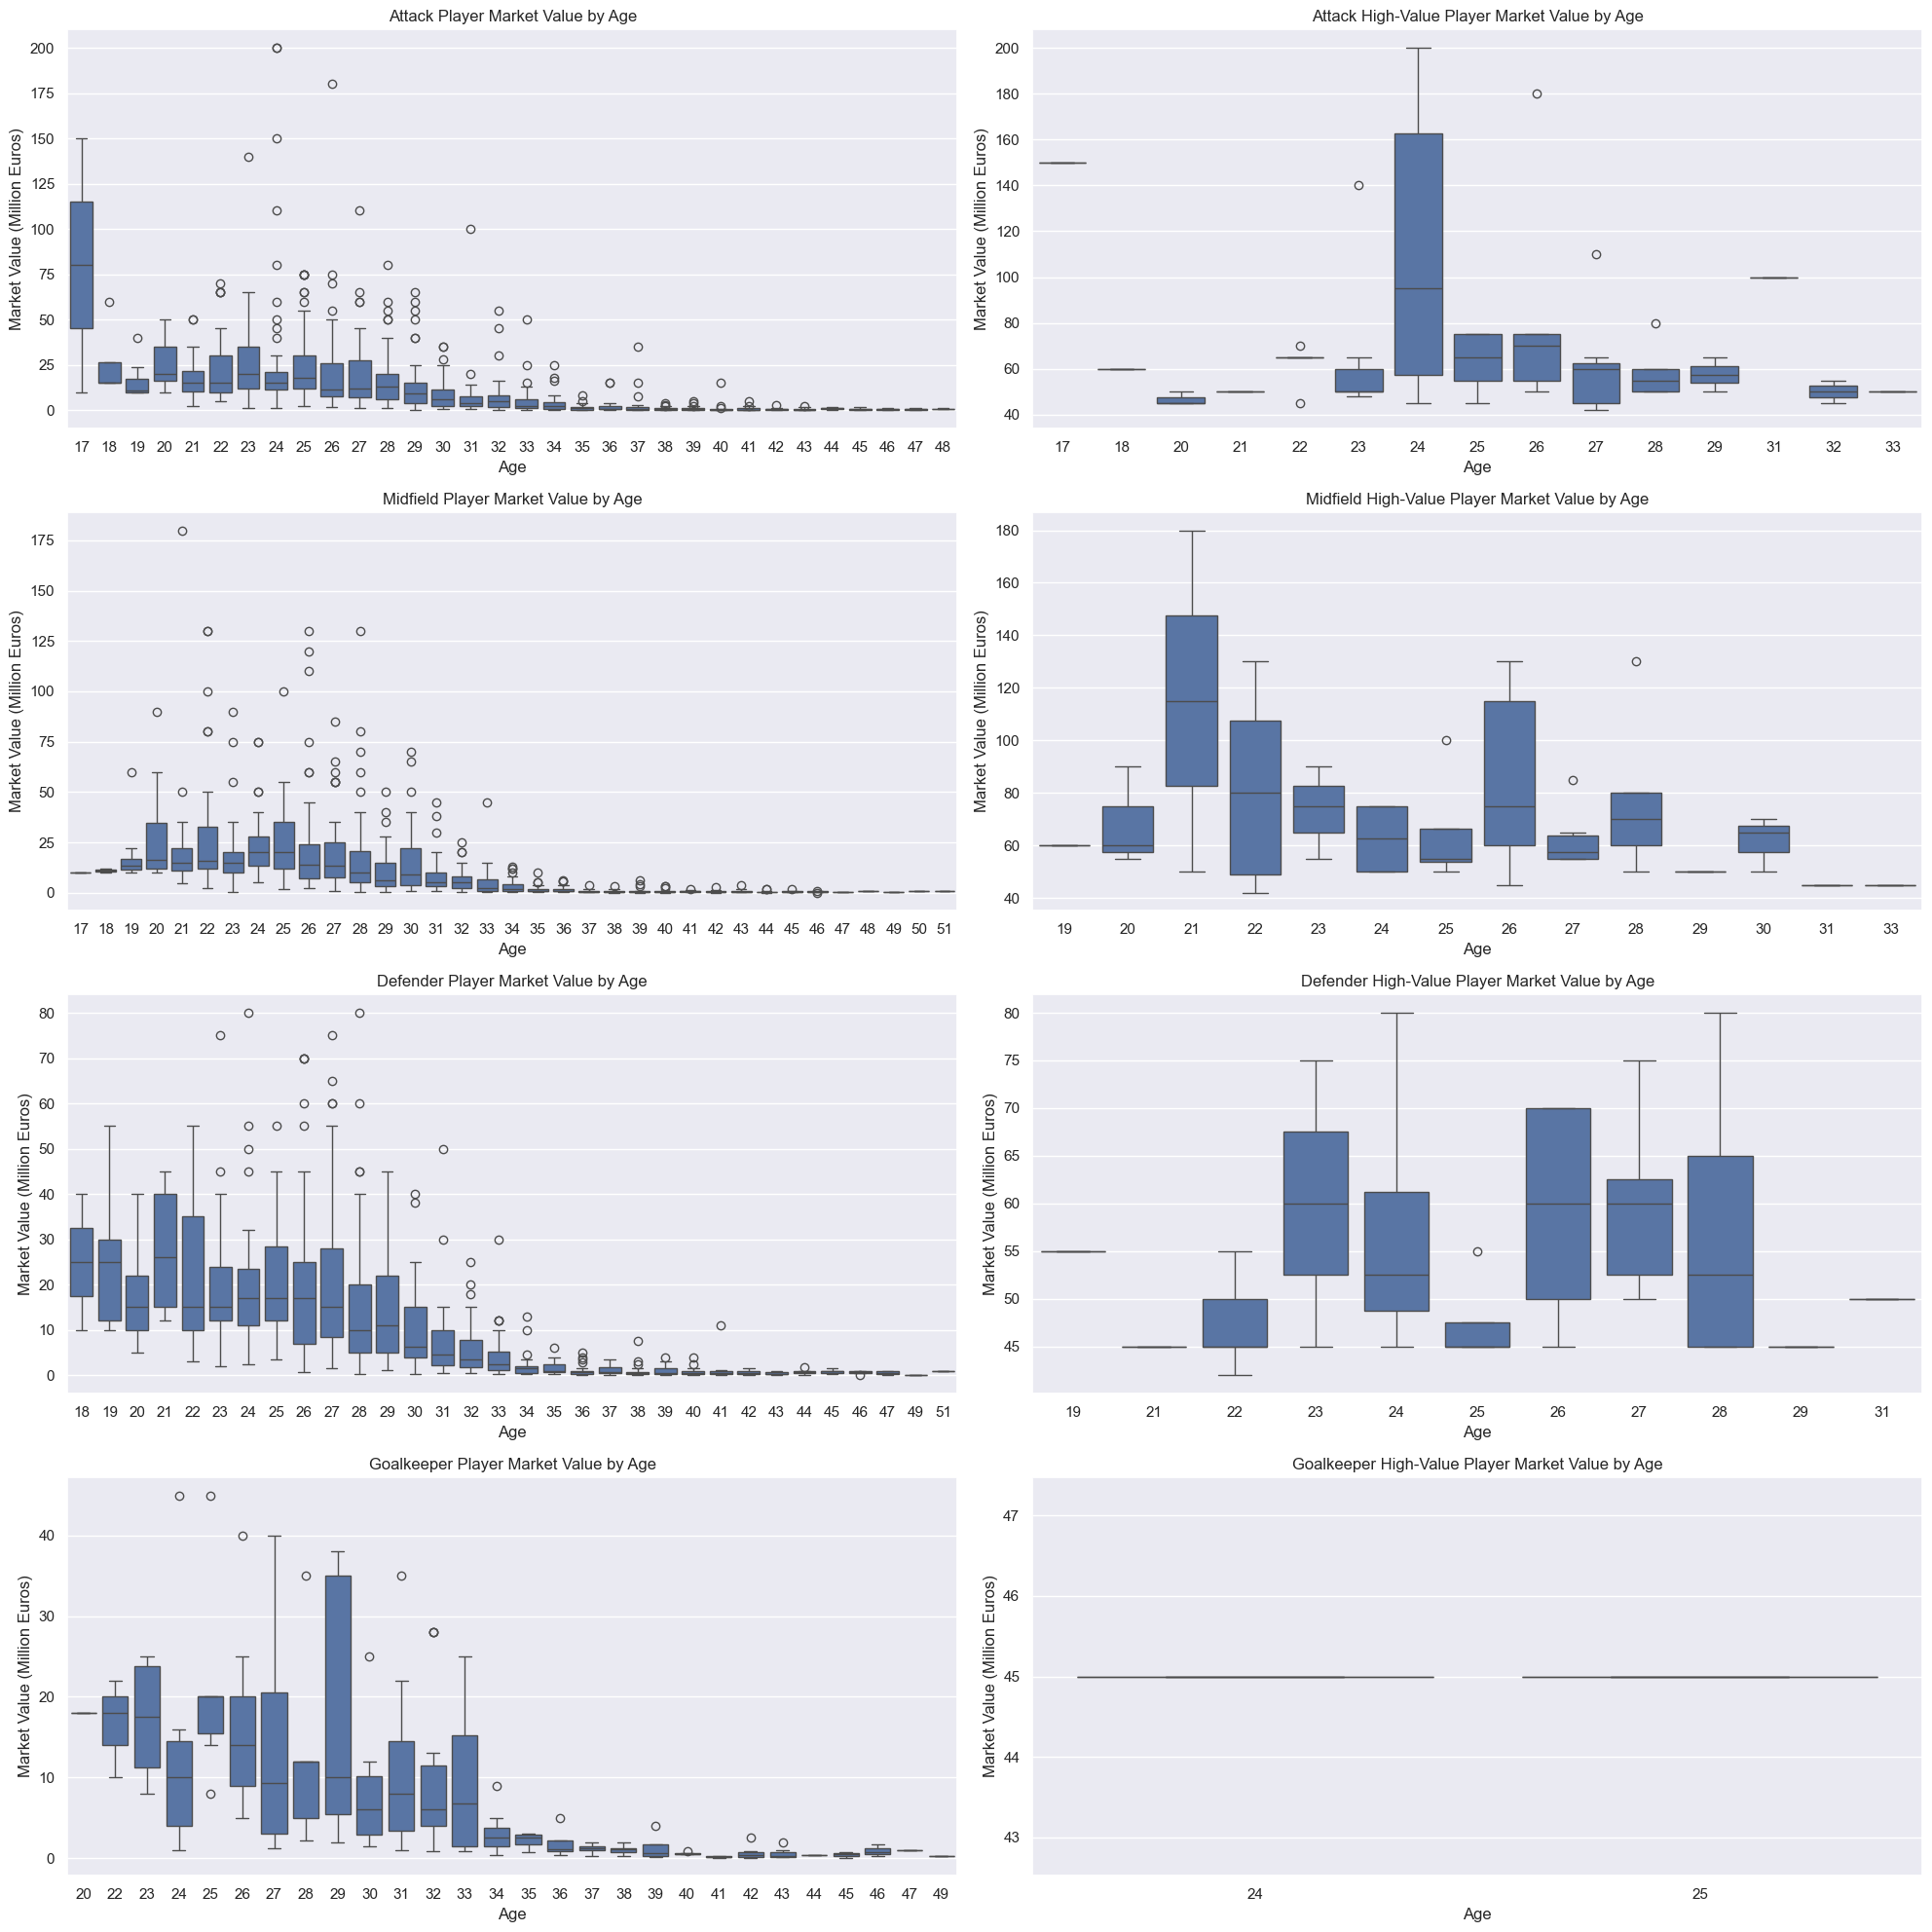

In [92]:
# Set color palette to rainbow
sns.set_palette("rainbow")

# Function to plot average market value by age for all players
def plot_market_value_by_age(data, title):
    sns.set(rc={'figure.figsize': (15, 7)})
    plt.figure()
    sns.boxplot(x=data["age"], y=data['market_value_in_eur'] / 1e6)
    plt.title(title)
    plt.ylabel('Market Value (Million Euros)')
    plt.xlabel('Age')
    plt.show()

# Function to plot market value by age for each position
def plot_market_value_by_position(data, high_value_data):
    unique_positions = data['position'].unique()
    plt.figure(figsize=(20, 20))

    for i, position in enumerate(unique_positions, 1):
        position_data = data[data['position'] == position]
        high_value_position_data = high_value_data[high_value_data['position'] == position]

        # Plot for all players in the position
        plt.subplot(len(unique_positions), 2, i * 2 - 1)
        sns.boxplot(x=position_data["age"], y=position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} Player Market Value by Age")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Age')

        # Plot for high-value players in the position
        plt.subplot(len(unique_positions), 2, i * 2)
        sns.boxplot(x=high_value_position_data["age"], y=high_value_position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} High-Value Player Market Value by Age")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Age')

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_market_value_by_age(players_df1, 'Average Market Value by Age (Million Euros)')
plot_market_value_by_position(players_df1, high_value_players_df)

### Observe more specific player valuations based on height

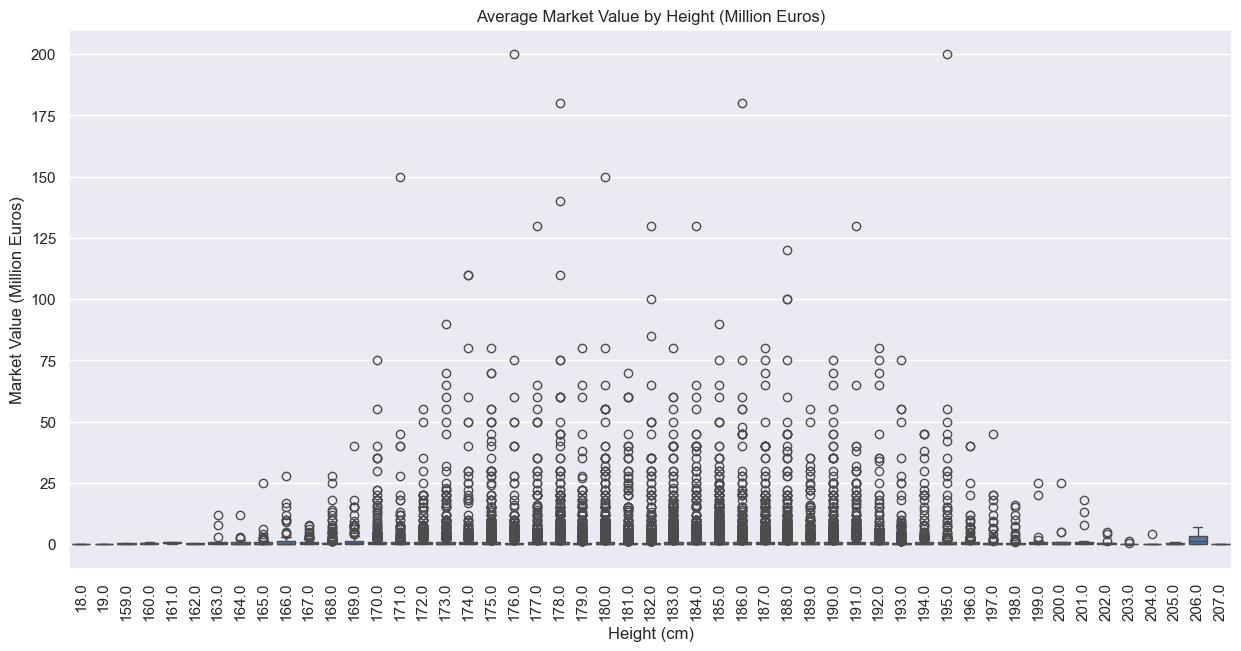

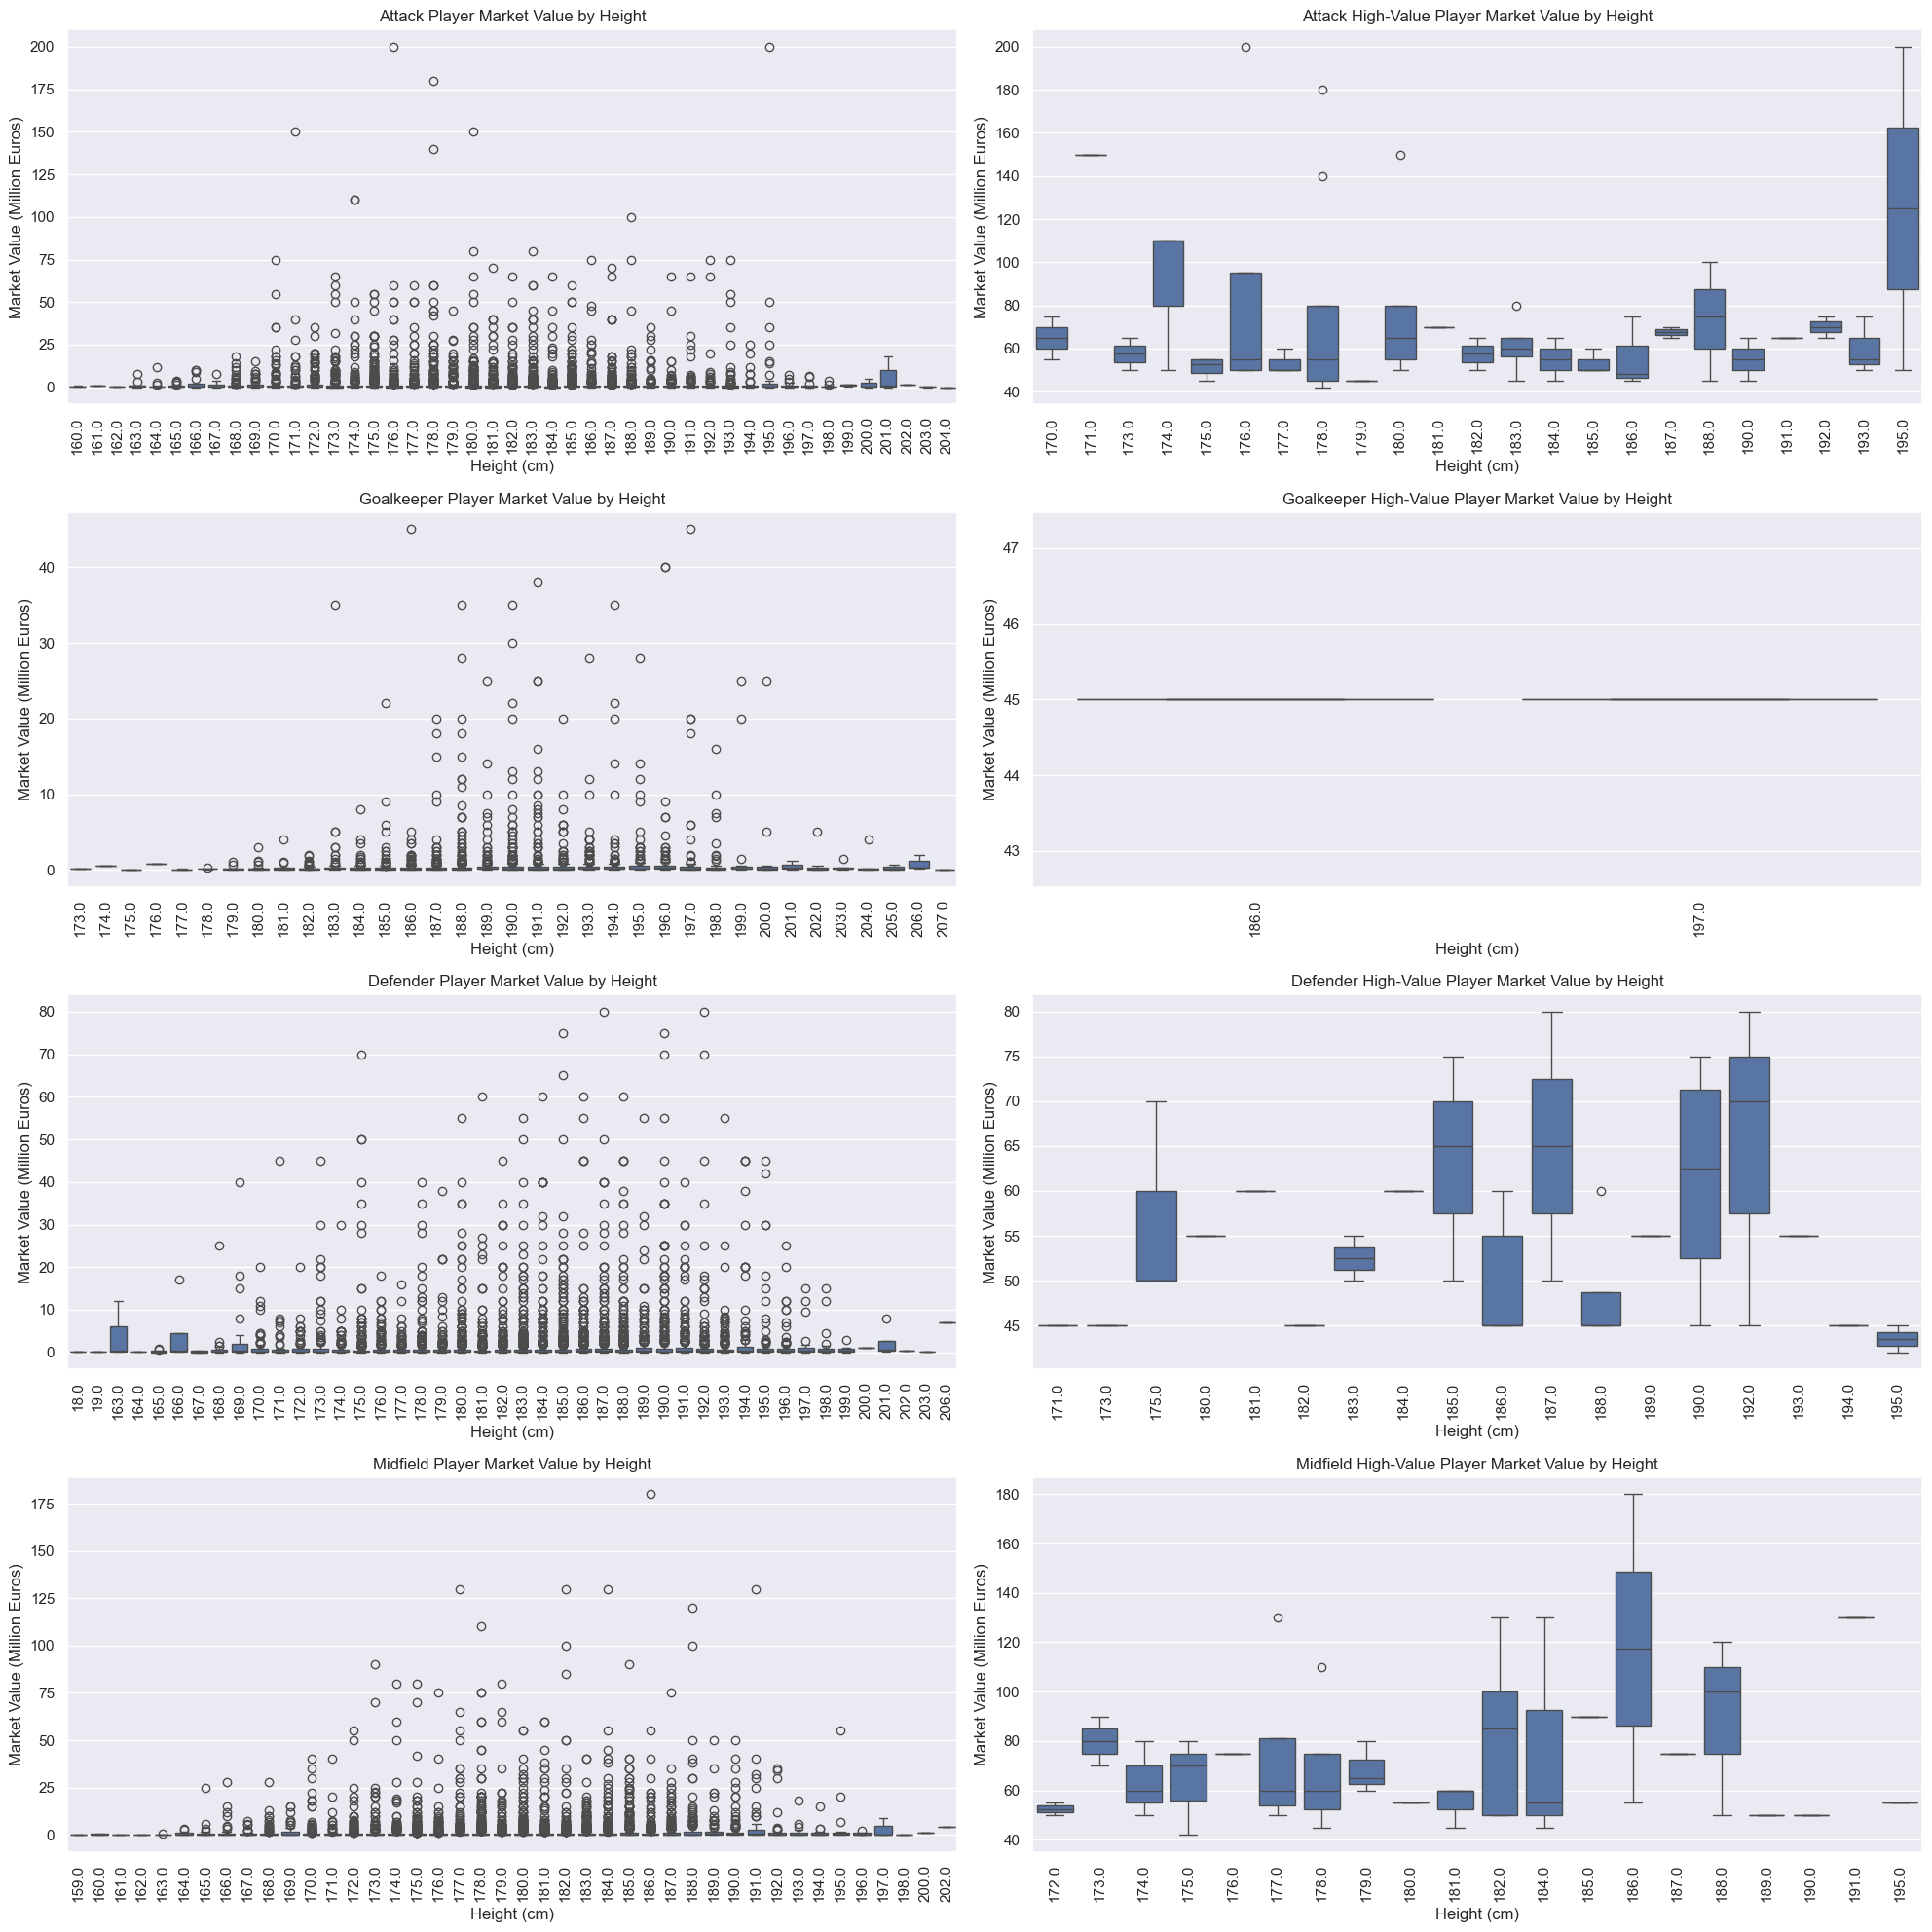

In [93]:
# Set color palette to rainbow
sns.set_palette("rainbow")

# Remove players with no height data
players_df3 = players_df[players_df['height_in_cm'] >= 1]

# Function to plot average market value by height for all players
def plot_market_value_by_height(data, title):
    sns.set(rc={'figure.figsize': (15, 7)})
    plt.figure()
    sns.boxplot(x=data["height_in_cm"], y=data['market_value_in_eur'] / 1e6)
    plt.title(title)
    plt.ylabel('Market Value (Million Euros)')
    plt.xlabel('Height (cm)')
    plt.xticks(rotation=90)  # Rotate x-axis labels
    plt.show()

# Function to plot market value by height for each position
def plot_market_value_by_position_height(data, high_value_data, positions):
    plt.figure(figsize=(20, 20))

    for i, position in enumerate(positions, 1):
        position_data = data[data['position'] == position]
        high_value_position_data = high_value_data[high_value_data['position'] == position]

        # Plot for all players in the position
        plt.subplot(len(positions), 2, i * 2 - 1)
        sns.boxplot(x=position_data["height_in_cm"], y=position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} Player Market Value by Height")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Height (cm)')
        plt.xticks(rotation=90)  # Rotate x-axis labels

        # Plot for high-value players in the position
        plt.subplot(len(positions), 2, i * 2)
        sns.boxplot(x=high_value_position_data["height_in_cm"], y=high_value_position_data['market_value_in_eur'] / 1e6)
        plt.title(f"{position} High-Value Player Market Value by Height")
        plt.ylabel('Market Value (Million Euros)')
        plt.xlabel('Height (cm)')
        plt.xticks(rotation=90)  # Rotate x-axis labels

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_market_value_by_height(players_df3, 'Average Market Value by Height (Million Euros)')
plot_market_value_by_position_height(players_df3, high_value_players_df, positions)

### Players with the top market values

In [94]:
# Define high value players dataframe (players with market value > 40 million EUR)
high_value_players_df1 = players_df[players_df['market_value_in_eur'] > 40000000]
high_value_players_df2 = high_value_players_df1.sort_values('market_value_in_eur', ascending=False)
highest_value_players_df2 = high_value_players_df1.sort_values('highest_market_value_in_eur', ascending=False)

print(high_value_players_df2[['name', "market_value_in_eur"]].head(15))
print()
print(highest_value_players_df2[['name', "highest_market_value_in_eur"]].head(15))

                    name  market_value_in_eur
19987    Vinicius Junior          200000000.0
21632     Erling Haaland          200000000.0
25746    Jude Bellingham          180000000.0
18780      Kylian Mbappé          180000000.0
21316         Phil Foden          150000000.0
31099       Lamine Yamal          150000000.0
22062        Bukayo Saka          140000000.0
26118      Florian Wirtz          130000000.0
19515              Rodri          130000000.0
19864  Federico Valverde          130000000.0
25709      Jamal Musiala          130000000.0
19520        Declan Rice          120000000.0
21463            Rodrygo          110000000.0
21312   Lautaro Martínez          110000000.0
17626    Martin Ødegaard          110000000.0

                    name  highest_market_value_in_eur
18780      Kylian Mbappé                  200000000.0
21632     Erling Haaland                  200000000.0
19987    Vinicius Junior                  200000000.0
5941              Neymar                  18000

## DATA MERGING

### Now let's use 2022 information to train and predict player valuations

In [95]:
# Merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022
merged_players_df = players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth', 'first_name', 'last_name', 'player_code'], axis=1)

# Create a function to collate player stats
def player_stats(player_id, season, df):
    df = df[(df['player_id'] == player_id) & (df['season'] == season)]
    if df.empty:
        return pd.DataFrame([(player_id, season, 0, 0, 0, 0, 0, 0, 0, 0, 0)], 
                            columns=['player_id', 'season', 'goals', 'games', 'assists', 'minutes_played', 'goals_for', 'goals_against', 'clean_sheet', 'yellow_cards', 'red_cards'])
    
    # Calculate specific statistics
    df['goals_for'] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                               else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                               else np.nan, axis=1)
    
    df['goals_against'] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                                   else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                                   else np.nan, axis=1)
    
    df['clean_sheet'] = df['goals_against'].apply(lambda x: 1 if x == 0 else (0 if x > 0 else np.nan))
    
    # Aggregate statistics by player_id and season
    stats = df.groupby(['player_id', 'season'], as_index=False).agg({
        'goals': 'sum', 
        'game_id': 'nunique', 
        'assists': 'sum', 
        'minutes_played': 'sum', 
        'goals_for': 'sum',
        'goals_against': 'sum', 
        'clean_sheet': 'sum', 
        'yellow_cards': 'sum', 
        'red_cards': 'sum'
    })
    
    return stats.rename(columns={'game_id': 'games'})

# Iterate through players and merge stats
for index, row in merged_players_df.iterrows():
    player_id = row['player_id']
    stats = player_stats(player_id, season, games_and_appearances_df)
    
    merged_players_df.at[index, 'games_{}'.format(season)] = stats['games'][0]
    merged_players_df.at[index, 'goals_{}'.format(season)] = stats['goals'][0]
    merged_players_df.at[index, 'assists_{}'.format(season)] = stats['assists'][0]
    merged_players_df.at[index, 'minutes_played_{}'.format(season)] = stats['minutes_played'][0]
    merged_players_df.at[index, 'goals_for_{}'.format(season)] = stats['goals_for'][0]
    merged_players_df.at[index, 'goals_against_{}'.format(season)] = stats['goals_against'][0]
    merged_players_df.at[index, 'clean_sheet_{}'.format(season)] = stats['clean_sheet'][0]
    merged_players_df.at[index, 'yellow_cards_{}'.format(season)] = stats['yellow_cards'][0]
    merged_players_df.at[index, 'red_cards_{}'.format(season)] = stats['red_cards'][0]

print('Appearance, goal, and card data merged')
print(merged_players_df.info())

Appearance, goal, and card data merged
<class 'pandas.core.frame.DataFrame'>
Index: 30843 entries, 0 to 32405
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             30843 non-null  int64  
 1   name                                  30843 non-null  object 
 2   country_of_birth                      28670 non-null  object 
 3   country_of_citizenship                30484 non-null  object 
 4   sub_position                          30743 non-null  object 
 5   position                              30843 non-null  object 
 6   foot                                  28872 non-null  object 
 7   height_in_cm                          29127 non-null  float64
 8   agent_name                            15954 non-null  object 
 9   current_club_domestic_competition_id  30843 non-null  object 
 10  current_club_name                     30843 non-

In [109]:
# Merge competitions data to get the competition name and rankings (Based on UEFA Rankings)
merged_df = merged_players_df.copy()
merged_df = merged_df.rename(columns={'name': 'player_name'})
merged_df = merged_df.merge(competitions_df[['competition_id', 'name']], 
                                            left_on='current_club_domestic_competition_id', 
                                            right_on='competition_id', 
                                            how='left')

merged_df = merged_df.drop('competition_id', axis=1)
merged_df = merged_df.rename(columns={'name': 'competition_name'})

# Create a dictionary to assign numerical rankings to competitions (you can adjust the mapping)
competition_ranking = {
    "uefa-champions-league": 1,
    "uefa-europa-league": 2,
    "uefa-conference-league": 3,
    "premier-league": 4,
    "laliga": 5,
    "bundesliga": 6,
    "serie-a": 7,
    "ligue-1": 8,
    "eredivisie": 9,
    "liga-portugal-bwin": 10,
    "jupiler-pro-league": 11,
    "super-lig": 12,
    "superligaen": 13,
    "premier-liga": 14,
    "super-league-1": 15,
    "scottish-premiership": 16,
    "premier-liga": 17,
    "uefa-super-cup": 18,
    "supercoppa-italiana": 19,
    "community-shield": 20,
    "fifa-klub-wm": 21,
    "italy-cup": 22,
    "supercopa": 23,
    "dfb-pokal": 24,
    "johan-cruijff-schaal": 25,
    "kypello-elladas": 26,
    "supertaca-candido-de-oliveira": 27,
    "russian-super-cup": 28,
    "sydbank-pokalen": 29,
    "allianz-cup": 30,
    "toto-knvb-beker": 31,
    "sfa-cup": 32,
    "ukrainian-cup": 33,
    "trophee-des-champions": 34,
    "efa-cup": 35
}

# Map the competition_name to its rank using the dictionary
merged_df['competition_rank'] = merged_df['competition_name'].map(competition_ranking)
merged_df = merged_df.drop('highest_market_value_in_eur', axis=1)
merged_df = merged_df.dropna()
merged_df

,player_id,player_name,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,current_club_name,...,goals_2022,assists_2022,minutes_played_2022,goals_for_2022,goals_against_2022,clean_sheet_2022,yellow_cards_2022,red_cards_2022,competition_name,competition_rank
0,10,Miroslav Klose,Poland,Germany,Centre-Forward,Attack,right,184.0,IT1,Società Sportiva Lazio S.p.A.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,serie-a,7
1,26,Roman Weidenfeller,Germany,Germany,Goalkeeper,Goalkeeper,left,190.0,L1,Borussia Dortmund,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
4,80,Tom Starke,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.0,L1,FC Bayern München,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
7,132,Tomas Rosicky,CSSR,Czech Republic,Attacking Midfield,Midfield,both,179.0,GB1,Arsenal Football Club,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,premier-league,4
8,162,Marc Ziegler,Germany,Germany,Goalkeeper,Goalkeeper,right,193.0,L1,Verein für Bewegungsspiele Stuttgart 1893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bundesliga,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30831,1247360,Ivan M'Bahia,Cote d'Ivoire,Cote d'Ivoire,Centre-Back,Defender,right,174.0,FR1,Clermont Foot 63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ligue-1,8
30837,1294048,Alex Marques,Portugal,Portugal,Centre-Back,Defender,right,186.0,PO1,Boavista Futebol Clube,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10
30838,1294049,Tomás Silva,Portugal,Portugal,Left-Back,Defender,left,175.0,PO1,Boavista Futebol Clube,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10
30839,1294052,João Barros,Portugal,Portugal,Left Winger,Attack,right,184.0,PO1,Boavista Futebol Clube,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,liga-portugal-bwin,10


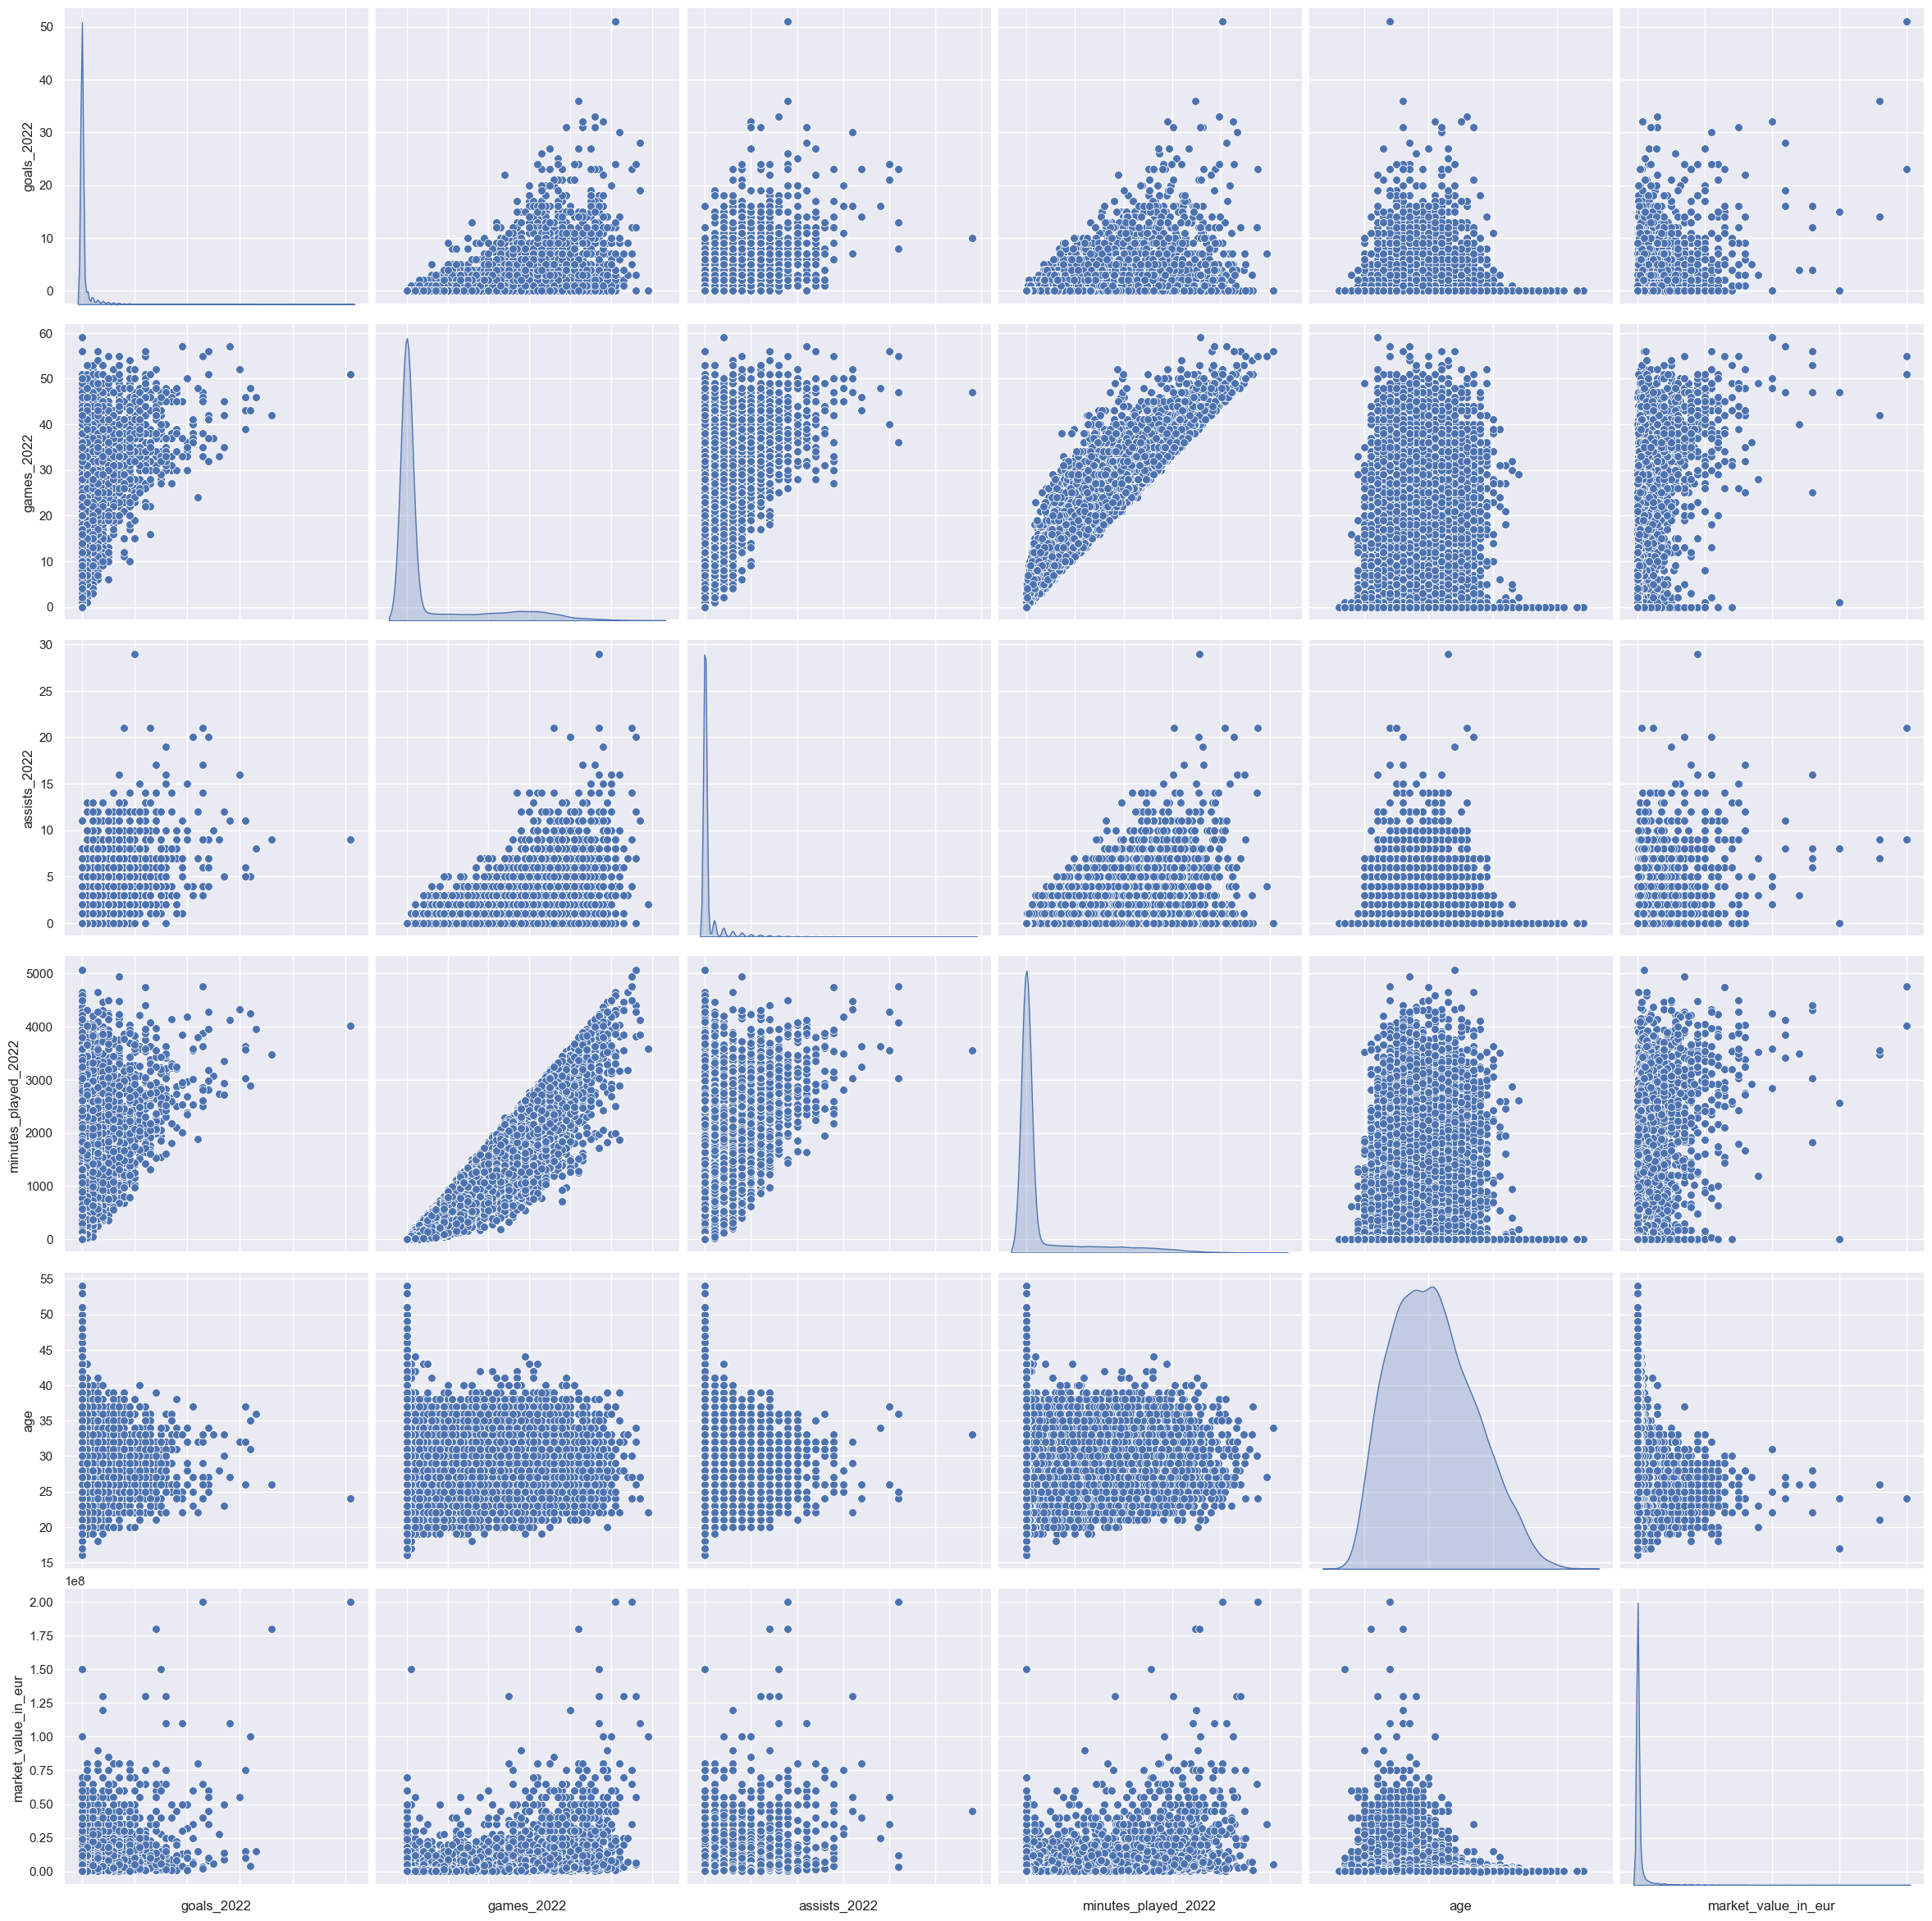

In [76]:
## Plot the pairplot
g = sns.pairplot(merged_df[[u'goals_2022', u'games_2022', u'assists_2022', u'minutes_played_2022',u'age',u'market_value_in_eur']], palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

Index(['height_in_cm', 'market_value_in_eur', 'age', 'games_2022',
       'goals_2022', 'assists_2022', 'minutes_played_2022', 'goals_for_2022',
       'goals_against_2022', 'clean_sheet_2022', 'yellow_cards_2022',
       'red_cards_2022', 'competition_rank'],
      dtype='object')


<Axes: title={'center': 'Pearson Correlation of Features'}>

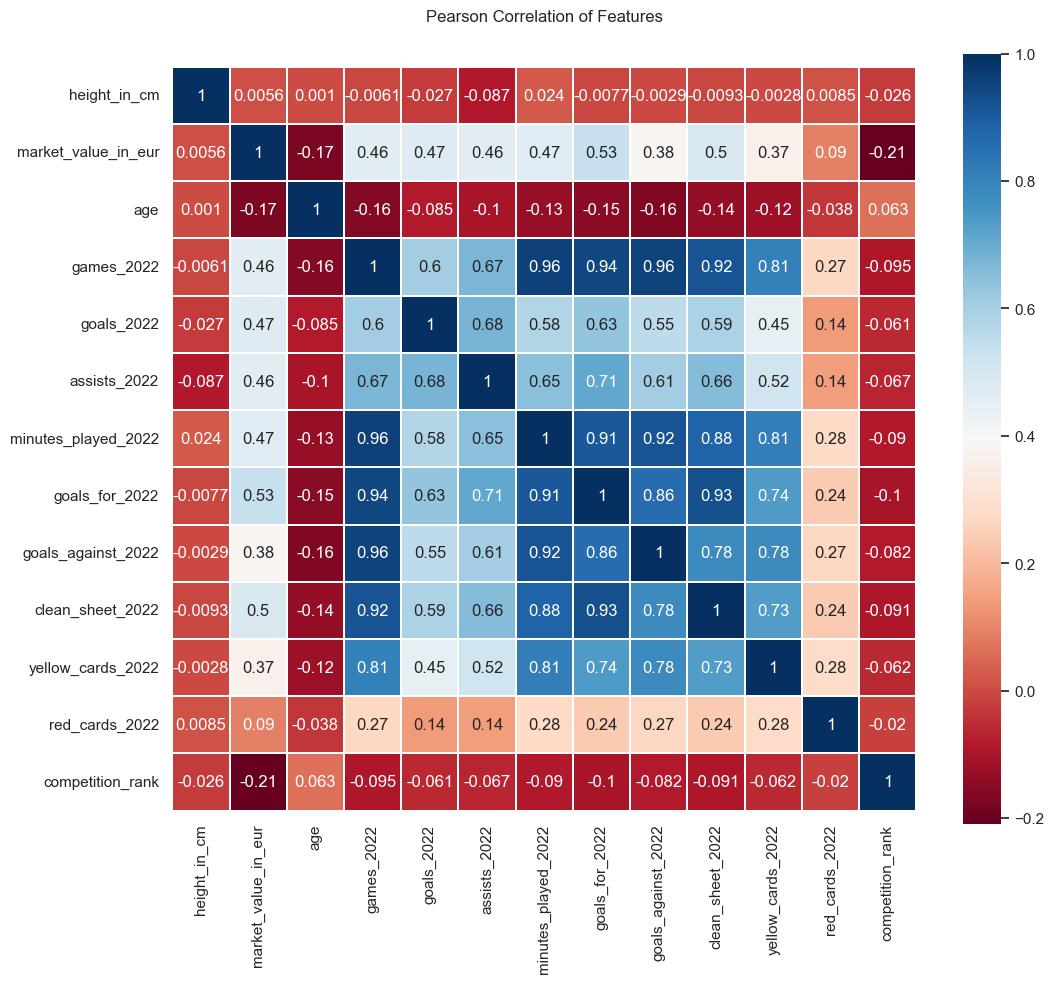

In [92]:
# Plot a Pearson Correlation Diagram
colormap = plt.cm.RdBu
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Features', y=1.05)

features_df=merged_df.drop(['player_id', 'player_name', 'competition_name', 'position', 'sub_position', 'foot', 'country_of_citizenship', 'country_of_birth', 'current_club_name', 'current_club_domestic_competition_id'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

## Training Models

In [158]:
# train test split the dataset
test_df = features_df[['market_value_in_eur', 'age', 'games_2022', 'goals_2022', 'assists_2022', 'minutes_played_2022', 'goals_for_2022', 'goals_against_2022', 'clean_sheet_2022', 'yellow_cards_2022', 'red_cards_2022', 'competition_rank', 'height_in_cm']]
X = test_df.drop(columns=["market_value_in_eur"])
y1 = np.log1p(test_df["market_value_in_eur"]) # log to make the market value smaller

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

### Linear Regression

In [159]:
# try a Linear Regression model
LnrReg1 = LinearRegression().fit(X_train, y1_train)
y1_pred_lnr = LnrReg1.predict(X_test)

mae_lnr = mean_absolute_error(y1_test, y1_pred_lnr)
mse_lnr = mean_squared_error(y1_test, y1_pred_lnr)
rmse_lnr = np.sqrt(mse_lnr)
r2_lnr = r2_score(y1_test, y1_pred_lnr)

print(f"Linear Regression Results:")
print(f"Mean Absolute Error (MAE): {mae_lnr}")
print(f"Mean Squared Error (MSE): {mse_lnr}")
print(f"Root Mean Squared Error (RMSE): {rmse_lnr}")
print(f"R-squared (R²): {r2_lnr}")

Linear Regression Results:
Mean Absolute Error (MAE): 0.9141466503662999
Mean Squared Error (MSE): 1.3843860126307634
Root Mean Squared Error (RMSE): 1.1765993424402224
R-squared (R²): 0.4473048475327568


### Lasso

In [160]:
# try a Lasso model
Lasso1 = Lasso().fit(X_train, y1_train)
y1_pred_las = Lasso1.predict(X_test)

mae_las = mean_absolute_error(y1_test, y1_pred_las)
mse_las = mean_squared_error(y1_test, y1_pred_las)
rmse_las = np.sqrt(mse_las)
r2_las = r2_score(y1_test, y1_pred_las)

print(f"Lasso Results:")
print(f"Mean Absolute Error (MAE): {mae_las}")
print(f"Mean Squared Error (MSE): {mse_las}")
print(f"Root Mean Squared Error (RMSE): {rmse_las}")
print(f"R-squared (R²): {r2_las}")

Lasso Results:
Mean Absolute Error (MAE): 0.9374857633085957
Mean Squared Error (MSE): 1.4928005447593713
Root Mean Squared Error (RMSE): 1.221802170876845
R-squared (R²): 0.40402198724827676


### Random Forest Regressor

In [165]:
# try a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y1_train)
y1_pred_rf = rf_regressor.predict(X_test)

mae_rf = mean_absolute_error(y1_test, y1_pred_rf)
mse_rf = mean_squared_error(y1_test, y1_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y1_test, y1_pred_rf)

print(f"Random Forest Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R²): {r2_rf}")

Random Forest Regressor Results:
Mean Absolute Error (MAE): 0.9287914987849204
Mean Squared Error (MSE): 1.4936332215473365
Root Mean Squared Error (RMSE): 1.222142880987054
R-squared (R²): 0.4036895536494962


### XGBoost Regressor

In [166]:
# try a XGBoost Regressor model
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_regressor.fit(X_train, y1_train)
y1_pred_xgb = xgb_regressor.predict(X_test)

mae_xgb = mean_absolute_error(y1_test, y1_pred_xgb)
mse_xgb = mean_squared_error(y1_test, y1_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y1_test, y1_pred_xgb)

print(f"XGBoost Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R-squared (R²): {r2_xgb}")

XGBoost Regressor Results:
Mean Absolute Error (MAE): 0.8376069769921892
Mean Squared Error (MSE): 1.2060825034681861
Root Mean Squared Error (RMSE): 1.0982178761376025
R-squared (R²): 0.5184898236036897
